## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [58]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [59]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [60]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [61]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [62]:
data['cabin'].head()

0     B5
1    C22
2    C22
3    C22
4    C22
Name: cabin, dtype: object

In [63]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [64]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    object 
 13  home.dest  745 non-null    object 
 14  title      1309 non-null   object 
dtypes: float64(2), int64(4), object(9)
memory usage: 153.5+ KB


In [66]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [67]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [68]:
target = 'survived'

In [69]:
vars_num = [col for col in data.columns if data[col].dtype != 'object' and col != target]

vars_cat = [col for col in data.columns if data[col].dtype == 'object']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [70]:
# first in numerical variables
data[vars_num].isnull().sum()

pclass      0
age       263
sibsp       0
parch       0
fare        1
dtype: int64

In [71]:
# now in categorical variables
data[vars_cat].isnull().sum()


sex            0
cabin       1014
embarked       2
title          0
dtype: int64

### Determine cardinality of categorical variables

In [72]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

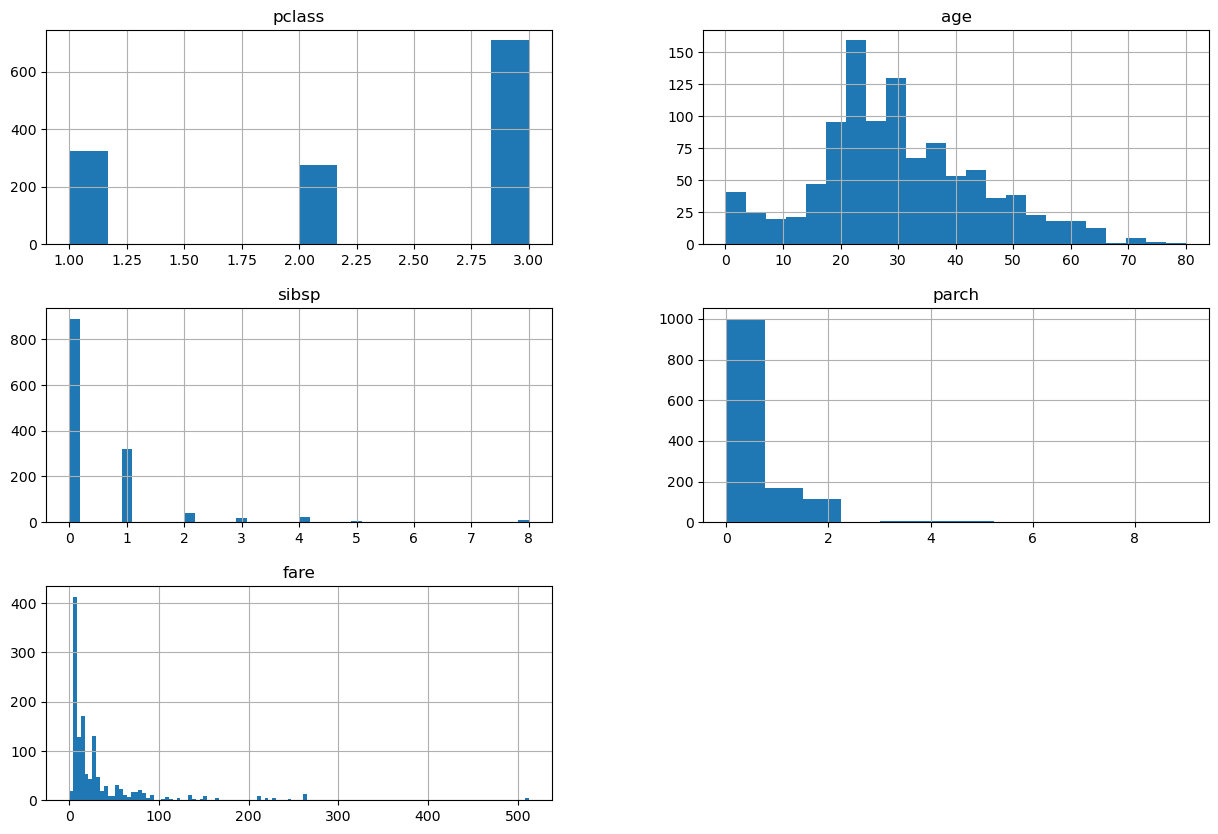

In [73]:
data[vars_num].hist(bins='auto', figsize=(15,10))
plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [75]:
# Extract the letter from the cabin column
X_train['cabin'] = X_train['cabin'].str[:1]
X_test['cabin'] = X_test['cabin'].str[:1]

X_train['cabin'].unique()

array([nan, 'E', 'F', 'A', 'C', 'D', 'B', 'T', 'G'], dtype=object)

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [76]:
for var in ['age', 'fare']:
    X_train[var+'_NA'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_NA'] = np.where(X_test[var].isnull(), 1, 0)

    median = X_train[var].median()
    
    X_train[var].fillna(median, inplace=True)
    X_test[var].fillna(median, inplace=True)

X_train[['age','fare']].isnull().sum()

C:\Users\omsri\AppData\Local\Temp\ipykernel_16920\2389879078.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[var].fillna(median, inplace=True)
C:\Users\omsri\AppData\Local\Temp\ipykernel_16920\2389879078.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

age     0
fare    0
dtype: int64

In [77]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1047 entries, 1118 to 684
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1047 non-null   int64  
 1   sex       1047 non-null   object 
 2   age       1047 non-null   float64
 3   sibsp     1047 non-null   int64  
 4   parch     1047 non-null   int64  
 5   fare      1047 non-null   float64
 6   cabin     244 non-null    object 
 7   embarked  1045 non-null   object 
 8   title     1047 non-null   object 
 9   age_NA    1047 non-null   int32  
 10  fare_NA   1047 non-null   int32  
dtypes: float64(2), int32(2), int64(3), object(4)
memory usage: 90.0+ KB


### Replace Missing data in categorical variables with the string **Missing**

In [78]:
X_train[vars_cat] = X_train[vars_cat].fillna('Missing')
X_test[vars_cat] = X_test[vars_cat].fillna('Missing')

In [79]:
X_train.isnull().sum()


pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
cabin       0
embarked    0
title       0
age_NA      0
fare_NA     0
dtype: int64

In [80]:
X_test.isnull().sum()

pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
cabin       0
embarked    0
title       0
age_NA      0
fare_NA     0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [81]:
def find_frequent_labels(df, var, rare_perc):
    
    df = df.copy()
    tmp = df.groupby(var)[var].count() / len(df)
    return tmp[tmp > rare_perc].index


for var in vars_cat:
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    
    X_train[var] = X_train[var].where(X_train[var].isin(frequent_ls), 'Rare')
    X_test[var]  = X_test[var].where(X_test[var].isin(frequent_ls),  'Rare')


In [82]:
X_train[vars_cat].nunique()

sex         2
cabin       3
embarked    4
title       4
dtype: int64

In [83]:
X_test[vars_cat].nunique()

sex         2
cabin       3
embarked    3
title       4
dtype: int64

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [84]:
for var in vars_cat:
    
    X_train = pd.concat([X_train,
                         pd.get_dummies(X_train[var], prefix=var, drop_first=True)
                         ], axis=1)
    
    X_test = pd.concat([X_test,
                        pd.get_dummies(X_test[var], prefix=var, drop_first=True)
                        ], axis=1)
    

X_train.drop(labels=vars_cat, axis=1, inplace=True)
X_test.drop(labels=vars_cat, axis=1, inplace=True)

X_train.shape, X_test.shape

((1047, 16), (262, 15))

In [85]:
X_train.head()

,pclass,age,sibsp,parch,fare,age_NA,fare_NA,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_Rare,embarked_S,title_Mr,title_Mrs,title_Rare
1118,3,25.0,0,0,7.9250,0,0,True,True,False,False,False,True,True,False,False
44,1,41.0,0,0,134.5000,0,0,False,False,True,False,False,False,False,False,False
1072,3,28.0,0,0,7.7333,1,0,True,True,False,True,False,False,True,False,False
1130,3,18.0,0,0,7.7750,0,0,False,True,False,False,False,True,False,False,False
574,2,29.0,1,0,21.0000,0,0,True,True,False,False,False,True,True,False,False


In [86]:
X_test.head()

,pclass,age,sibsp,parch,fare,age_NA,fare_NA,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_S,title_Mr,title_Mrs,title_Rare
1139,3,38.0,0,0,7.8958,0,0,True,True,False,False,True,True,False,False
533,2,21.0,0,1,21.0000,0,0,False,True,False,False,True,False,False,False
459,2,42.0,1,0,27.0000,0,0,True,True,False,False,True,True,False,False
1150,3,28.0,0,0,14.5000,1,0,True,True,False,False,True,True,False,False
393,2,25.0,0,0,31.5000,0,0,True,True,False,False,True,True,False,False


In [87]:
X_test['embarked_Rare'] = 0

In [57]:
variables = [c  for c in X_train.columns]

variables

['pclass',
 'age',
 'sibsp',
 'parch',
 'fare',
 'age_NA',
 'fare_NA',
 'sex_male',
 'cabin_Missing',
 'cabin_Rare',
 'embarked_Q',
 'embarked_Rare',
 'embarked_S',
 'title_Mr',
 'title_Mrs',
 'title_Rare']

### Scale the variables

- Use the standard scaler from Scikit-learn

In [88]:
scaler = StandardScaler()
scaler.fit(X_train[variables]) 

X_train = scaler.transform(X_train[variables])
X_test = scaler.transform(X_test[variables])

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [89]:
model = LogisticRegression(C=0.0005, random_state=0)
model.fit(X_train, y_train)

LogisticRegression(C=0.0005, random_state=0)

In [93]:
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier(
                                n_estimators=100, 
                                max_depth=None,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                random_state=42,
                                n_jobs=-1
                                )
model1.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [94]:
# make predictions for test set
class_ = model.predict(X_train)
pred = model.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

# make predictions for test set
class_ = model.predict(X_test)
pred = model.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))
print()

train roc-auc: 0.8431684698608964
train accuracy: 0.7125119388729704

test roc-auc: 0.835462962962963
test accuracy: 0.7022900763358778



In [95]:
# make predictions for test set
class_ = model1.predict(X_train)
pred = model1.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

# make predictions for test set
class_ = model1.predict(X_test)
pred = model1.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))
print()

train roc-auc: 0.9967619783616694
train accuracy: 0.9770773638968482

test roc-auc: 0.8390740740740741
test accuracy: 0.7938931297709924



That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**